# Sketching Least Squares Problems with Convex Constraints.

The purpose of this work is to use randomised transforms, aka _sketches_ of data to solve least squares regression problems with constraints over convex sets more quickly.  The setup is as follows:

Input:
* $A \in \mathbb{R}^{n \times d}$ is a sample-feature matrix
* $b \in \mathbb{R}^n$ is a target vector
* A set of convex constraints $\mathcal{C} \subset \mathbb{R}^d$.  For example, ridge constraints: $\mathcal{C} = \{ x \in \mathbb{R}^d : \| x \|_2 \le t \}$, or LASSO contraints $\mathcal{C} = \{ x \in \mathbb{R}^d : \| x \|_1 \le t \}$

Problem:
The initial problem is to find $x_{OPT} = \text{argmin}_{x \in \mathcal{C}} f(x)$ where $f(x) = \| Ax - b \|_2^2$.
The question is whether there is a general approach to finding $x_{OPT}$ over any convex constraints in a tractable manner.

It has been shown in  [1] that an iterative method of the following form can recover $x_{OPT}$:

_Iterative Hessian Sketch_
1. Initialise x^{0} = \mathbf{0}
2. For iterations $t = 0,1,2, \ldots, N-1$ do:
3. Generate a random sketch $S^{t+1} \in \mathbb{R}^{m \times n}$
4. Perform updates $x^{t+1} \leftarrow \text{argmin}_{x \in \mathcal{C}} \frac{1}{2m} \|S^{t+1} A(x-x^t)\|_2^2 - \langle A^T(y-Ax^t), x-x^t \rangle$
5. Return $x = x^N$.

NB. If using the link above for reference, the pseudocode in the text (Eqn 24) is incorrect and should have updates as in line 4.


### What is the sketching matrix $S$ ?
The matrix $S$ is chosen from a random family of matrices which map high dimensional vectors into lower dimensional vectors while still preserving their $\ell_2$ norm.  Matrices which satisfy this are known as Johnson-Lindenstrauss transforms.  The important property is that inner products are preserved so that for all vectors in the column span of a matrix we have the property that $(1-\epsilon) \| Ax \|_2^2 \le \| SAx \|_2^2 \le (1+\epsilon) \| Ax \|_2^2$. This can be advantagous when $n$ is very large because the matrix $S$ can be chosen to have $m \approx \epsilon^{-2} d \log d$ rows   Examples are (but not limited to)

1. _Gaussian_ matrices with entries chosen from standard normal distribution then rescaled to get unit covariance: $R_{ij} \sim N(0,1)$ and set $S = \frac{1}{\sqrt{k}} R \in \mathbb{R}^{k \times n}$.  This is dense and slow to apply.

2. Subsampled Randomized Hadamard Transform (_SRHT_ or _FJLT_ for fast Johnson-Lindenstrauss Tranform).
Let $S = \frac{1}{\sqrt{rn}} P H_n D$ where $D$ is a $n \times n$ diagonal matrix with $\pm 1$ each with probability 0.5, $H_n$ is the Hadamard Transform of size $n$, and $P$ is an $r \times n$ matrix which samples $r$ coordinate from $n$ uniformly at random. Ref: [2] - Theorem 2.4, check constants, they divide out by $k$ but possibly typo. Because $S$ is so highly structured it is fast to apply in general.

3. _CountSketch_ matrix.
An extremely sparse matrix which still maintains the distance-preserving properties from (1) and (2) but is constructed as follows:

Initialise $S = \mathbf{0}$. For every column $j = 1, \ldots, n$ select uniformly at random a row denoted $h(j) \in \{1,2,\ldots, m \}$ and then set $S_{j, h(j)} = \sigma (j)$ where $\sigma (j)$ is $\pm 1$ with probability 1/2.

Due to the sparsity of this transform, it is possible to multiply by a matrix $A$ in time which looks something like $O( \text{nnz}(A))$ where $\text{nnz}(A)$ denotes the number of nonzeros The _CountSketch_ matrix has an implementation in SciPy https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.clarkson_woodruff_transform.html
The implementation doesn't take advantage of sparsity in data so may not quite achieve the asymptotic time cost.



## Goals of the project
Below are outlined some preliminary experiments on small-scale synthetic data simply to check that the _CountSketch_ transform does in fact work as well as the Gaussian transform.  However, the Gaussian transform is realistically too slow to apply to compare to methods (2) and (3) and hence may not be favourable.   It would be good to explore:

* In what regimes in which method (3) is faster than method (2).  Does this hold for all data, or just sparse data as the theory suggsts?
* If there is a sparse regime in which (3) is favourable then is there a 'crossing' point of data sparsity at which it then switches over to (2) being faster?
* What is the accuracy of using methods (2) and (3) in comparison to the standard solvers?
* Can we generate a suite of test and example cases which illustrate the benefits of a particular method (2) or (3) for say OLS, Ridge, LASSO, Elastic Net, SVM
* can we find real data examples for which the benefit of (3) is clear?

Longer Term:
* Apply it in a distributed setting with each machine receiving a subset of the rows.
* Does the faster update time update time allow for quicker training of ML models? Looking more towards Elastic net and SVM.

### References
1. https://arxiv.org/abs/1411.0347
2. http://www.cs.cmu.edu/afs/cs/user/dwoodruf/www/wNow3.pdf

Here I will illustrate that method (3) can be shown to work in the same sense as method (1) i.e. it can be used to recover the solution for OLS. I haven't measured time or space requirements and don't yet have an implementation of method (2).  An interesting side project might be to implement a robust FJLT for (2) and submit to sklearn which currently lacks this feature.

In [1]:
import numpy as np
import scipy as sp
from sklearn.datasets import make_regression
from scipy.optimize import minimize
from scipy.linalg import clarkson_woodruff_transform 

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.linalg import norm

## 1. Ordinary Least Squares
To check that (3) has any hope of working I implemented it for OLS.  This is a special case of the constrained problems where $\mathcal{C} = \mathbb{R}^d$ i.e the problem is unconstrained.

First I have defined the Gaussian sketch as outlined in (1).  Since writing the code I have seen that this is also implemented in sklearn `from sklearn.random_projection import GaussianRandomProjection` but haven't got round to looking at this or changing the code yet.

In [2]:
def gaussian_sketch(nrows, ncols):
    '''Generate a Gausian sketching matrix of size
    (nrows, ncols)'''
    return (1/np.sqrt(nrows))*np.random.randn(nrows, ncols)

In [3]:
def generate_data(nsamples, nfeatures, variance=1):
    '''Generates a data matrix of size (nsamples, nfeatures)
    which defines a linear relationship on the variables.
    
    Can't really remember why I wrote this function.'''
    
    X, y, coef = make_regression(n_samples=nsamples, n_features=nfeatures,\
                        n_informative=nfeatures,noise=variance,coef=True)
    #X[:,0] = np.ones(shape=(nsamples)) # add bias terms
    return X, y, coef

### Hessian Sketching Methods

In [4]:
def iterative_hessian(data, targets, sketch_size, num_iters):
    '''
    INPUT:
    data - n x d matrix
    targets - n x 1 target variables
    num_iters - how many iterations to perform.  
    Need log(1/eps) -- > num_iters for eps accuracy where
    eps is relative error in the semi-norm ||u-v||_A = 
    1/sqrt(n)*||A(u-v)||_2.
    
    OUTPUT:
    x0 - vector which approximately recovers the true solution to 
    the constrained problem
    
    
    
    TO DO:
    Add functionality for lower bound on sketch size
    '''
    A = data
    y = targets
    n,d = A.shape
    x0 = np.zeros(shape=(d,1))
    m = int(sketch_size) # sketching dimension
    
    ATy = A.T.dot(y)[:,None]
    covariance_mat = A.T.dot(A)
   
    for n_iter in range(int(num_iters)):
        S = gaussian_sketch(m, n)
        S_A = S.dot(A)
        B = S_A.T.dot(S_A)
        z = ATy - covariance_mat.dot(x0) + np.dot(S_A.T, (np.dot(S_A,x0)))
        sol = sp.linalg.lstsq(B,z)
        x_new = sol[0] 
        
        
        ### KEEP BELOW AS THIS might BE USEful FOR LASSO OR
        ### PENALISED REGRESSION.
        
        #x0 = np.zeros((X.shape[0],1))
        #xt = np.zeros((2,1))
        #x_new = np.zeros((2,1))
        #for it in range(20):
        #    result = minimize(f2min, x0=x_new,args=(X,y,x_new),
        #                     method='L-BFGS-B', jac=False )
        #    print(result)
        #    x_new = result.x
        
        x_new = sp.linalg.solve(B,z)
        #print("ITERATION {}: ||x_t - x_t+1|| = {}".\
                  #format(n_iter, np.linalg.norm(x0-x_new)))
        x0 = x_new
    return np.ravel(x0)

In [5]:
def iterative_hessian_cwt(data, targets, sketch_size, num_iters):
    '''
    Input:
    data - n x d matrix
    targets - n x 1 target variables
    num_iters - how many iterations to perform.  
    Need log(1/eps) -- > num_iters for eps accuracy where
    eps is relative error in the semi-norm ||u-v||_A = 
    1/sqrt(n)*||A(u-v)||_2.
    
    
    Add functionality for lower bound on sketch size
    '''
    A = data
    y = targets
    n,d = A.shape
    x0 = np.zeros(shape=(d,1))
    m = int(sketch_size) # sketching dimension
    
    ATy = A.T.dot(y)[:,None]
    covariance_mat = A.T.dot(A)
   
    for n_iter in range(int(num_iters)):
        #S = gaussian_sketch(m, n)
        #S_A = S.dot(A)
        S_A = clarkson_woodruff_transform(A, sketch_size=m)
        # this implementations already has unit covariance
        # so no need to rescale
        B = S_A.T.dot(S_A)
        z = ATy - covariance_mat.dot(x0) + np.dot(S_A.T, (np.dot(S_A,x0)))
        sol = sp.linalg.lstsq(B,z)
        x_new = sol[0] 
        
        
        ### KEEP BELOW AS THIS WILL BE USED FOR LASSO OR
        ### PENALISED REGRESSION.
        
        #x0 = np.zeros((X.shape[0],1))
        #xt = np.zeros((2,1))
        #x_new = np.zeros((2,1))
        #for it in range(20):
        #    result = minimize(f2min, x0=x_new,args=(X,y,x_new),
        #                     method='L-BFGS-B', jac=False )
        #    print(result)
        #    x_new = result.x
        
        x_new = sp.linalg.solve(B,z)
        #print("ITERATION {}: ||x_t - x_t+1|| = {}".\
                  #format(n_iter, np.linalg.norm(x0-x_new)))
        x0 = x_new
    return np.ravel(x0)

The previous two cells are essentially the same code but with a different function call - either `gaussian_sketch` or `clarkson_woodruff_transform` so there is scope to just put these into one and alter the function definition.

#### Quick Test
Generate some data and check that both methods are converging to a solution.

In [6]:
XX,yy, coefXy = generate_data(1000,2)
print("True coefficients are: {}".format(coefXy))

True coefficients are: [ 39.67549701   3.05122298]


In [7]:
x_hat = iterative_hessian(XX,yy, XX.shape[0]//2, 10)
x_cwt = iterative_hessian_cwt(XX,yy, XX.shape[0]//2, 10)
x_true = sp.linalg.lstsq(XX,yy)
print("Gauss sketch coefficients are: {}".format(x_hat))
print("CWT sketch coefficients are: {}".format(x_hat))
print("The OLS estimates are: {}".format(x_true[0]))

Gauss sketch coefficients are: [ 39.66361369   3.08183291]
CWT sketch coefficients are: [ 39.66361369   3.08183291]
The OLS estimates are: [ 39.66361369   3.08183291]


/Users/cdickens/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


#### Reproducing the results of the paper [1] for OLS
Here I have (to some extent) reproduced the results of the paper.  The difference is that I think in the paper they used the FJLT and I have used Gaussian and CountSketch to compare and ensure the CountSketch exhibits the same properties.  The plots suggest that CountSketch does in fact work (I have since been able to prove why this is the case).


##### Experiment 1: Accuracy compared to problem size.

We need to produce two graphs each showing MSE and MS(prediction)E against the rows dimension $n$.  Parameter settings are as follows:
1. $n \in \{100,200, \ldots, 25600 \}$
2. $d=10$
3. Iterative Hessian sketch with $N = 1 + \text{ceil}(\log(n)$ rounds and $m=7d$
4. Sketch and solve approach with sketch size $M = Nm$

This is repeated over 300 trials with standard error bars in the paper - i won't do quite as many.

Sketch and solve is a method where instead of solving the exact problem or the IHS problem as I do here one solves $\text{argmin} \| S(Ax - b) \|_2 $.  It is a useful technique from the data streaming community but for ML is shown to be suboptimal.

In [8]:
# convert this to a dictionary method as used for second set of plots?

n_vals = [100*2**_ for _ in range(12)] # regression insatnce size i.e num rows of A
d = 10 # num features in the data
num_rounds = [np.log2(n_vals[_]) for _ in range(len(n_vals))] 
num_rounds = np.ceil(num_rounds) + 1
hessian_sketch_dimension = 7*d # Given in the paper

sketch_and_solve_dimension = [int(num_rounds[_]*hessian_sketch_dimension) for _ in range(len(num_rounds))] 

In [9]:
# Error metrics
mse_ls = np.zeros(shape=(len(n_vals),1))
mse_ihs = np.zeros_like(mse_ls)
mse_SkSol = np.zeros_like(mse_ls)
mse_cwt = np.zeros_like(mse_ls)


In [10]:
def test_all_methods_samples(num_tests):
    '''
    This function automates the testing procedure over each of the solving paradigms.
    The tests compare the optimal black box solution to the sketches.
    
    Input: number of tests to be run.
    
    Output: None but will draw graphs comparing the errors.
    
    The tests compare mean square error and prediction error for each method
    where prediction error is the norm of A(x_{OPT} - x_{ESTIMATE}) not a 
    train-test split.
    '''
    mse_ls = np.zeros(shape=(len(n_vals),1))
    mse_ihs = np.zeros_like(mse_ls)
    mse_cwt = np.zeros_like(mse_ls)
    mse_SkSol = np.zeros_like(mse_ls)

    pred_err_ls = np.zeros_like(mse_ls)
    pred_err_ihs = np.zeros_like(mse_ls)
    pred_err_cwt = np.zeros_like(mse_ls)
    pred_err_SkSol = np.zeros_like(mse_ls)


    for exp_no in range(num_tests):
        print("Trial number: {}".format(exp_no))
        # Fix the dataset
        X_full,y_full, x_star_full = generate_data(nsamples=n_vals[-1],
                                               nfeatures=d)

        for num_samples in range(len(n_vals)):
            print("Testing {} rows".format(n_vals[num_samples]))
            # Generate new data
            X = X_full[:n_vals[num_samples]]
            y = y_full[:n_vals[num_samples]]
            x_star = x_star_full[:n_vals[num_samples]]

            # plain regression
            optimal = sp.linalg.lstsq(X,y)
            x_ls = optimal[0]
            mse_ls[num_samples] += norm(x_star - x_ls,2)**2
            pred_err_ls[num_samples] += norm(X@(x_star[:,None] - x_ls[:,None]))**2

            # IHS  with Gaussian
            x_ihs = iterative_hessian(X, y, hessian_sketch_dimension,
                              num_rounds[num_samples])
            mse_ihs[num_samples] += norm(x_star - x_ihs,2)**2
            pred_err_ihs[num_samples] += norm(X@(x_star[:,None] - x_ihs[:,None]))**2

            # IHS with cwt
            x_cwt = iterative_hessian_cwt(X, y, hessian_sketch_dimension,
                              num_rounds[num_samples])
            mse_cwt[num_samples] += norm(x_star - x_cwt,2)**2
            pred_err_cwt[num_samples] += norm(X@(x_star[:,None] - x_cwt[:,None]))**2

            # Sketch and Solve
            M = sketch_and_solve_dimension[num_samples]
            S = gaussian_sketch(nrows=M,ncols=X.shape[0])
            sk_optimal = sp.linalg.lstsq(S@X, S@y)
            x_sk = sk_optimal[0]
            mse_SkSol[num_samples] += norm(x_star - x_sk,2)**2
            pred_err_SkSol[num_samples] += norm(X@(x_star[:,None] - x_sk[:,None]))**2

    mse_ls /= len(range(num_tests))
    mse_ihs /= len(range(num_tests))
    mse_SkSol /= len(range(num_tests))
    mse_cwt /= len(range(num_tests))

    pred_err_ls /= len(range(num_tests))
    pred_err_ihs /= len(range(num_tests))
    pred_err_SkSol /= len(range(num_tests))
    pred_err_cwt /= len(range(num_tests))



    fig, ax = plt.subplots()

    ax.loglog(n_vals, mse_ls, 'o-', label="Least Squares")
    ax.loglog(n_vals, mse_ihs, 'o-', label="IHS-Gaussian")
    ax.loglog(n_vals, mse_cwt, 'o-', label="IHS-CWT")
    ax.loglog(n_vals, mse_SkSol, 'o-', label="Sketch-and-Solve")

    ax.legend()
    ax.set_title("MSE compared to row dimension")
    ax.set_xlabel("Row dimension $n$")
    ax.set_ylabel("$||x_{estimate} - x^*||^2$")

    fig1, ax1 = plt.subplots()

    ax1.loglog(n_vals, pred_err_ls, 'o-', label="Least Squares")
    ax1.loglog(n_vals, pred_err_ihs, 'o-', label="IHS-Gaussian")
    ax1.loglog(n_vals, pred_err_cwt, 'o-', label="IHS-cwt")
    ax1.loglog(n_vals, pred_err_SkSol, 'o-', label="Sketch-and-Solve")

    ax1.legend()
    ax1.set_title("Prediction error compared to row dimension")
    ax1.set_xlabel("Row dimension $n$")
    ax1.set_ylabel("$||A(x_{estimate} - x^*)||^2$")

Trial number: 0
Testing 100 rows
Testing 200 rows
Testing 400 rows
Testing 800 rows
Testing 1600 rows
Testing 3200 rows
Testing 6400 rows
Testing 12800 rows
Testing 25600 rows
Testing 51200 rows
Testing 102400 rows
Testing 204800 rows
Trial number: 1
Testing 100 rows
Testing 200 rows
Testing 400 rows
Testing 800 rows
Testing 1600 rows
Testing 3200 rows
Testing 6400 rows
Testing 12800 rows
Testing 25600 rows
Testing 51200 rows
Testing 102400 rows
Testing 204800 rows
Trial number: 2
Testing 100 rows
Testing 200 rows
Testing 400 rows
Testing 800 rows
Testing 1600 rows
Testing 3200 rows
Testing 6400 rows
Testing 12800 rows
Testing 25600 rows
Testing 51200 rows
Testing 102400 rows
Testing 204800 rows
Trial number: 3
Testing 100 rows
Testing 200 rows
Testing 400 rows
Testing 800 rows
Testing 1600 rows
Testing 3200 rows
Testing 6400 rows
Testing 12800 rows
Testing 25600 rows
Testing 51200 rows
Testing 102400 rows
Testing 204800 rows
Trial number: 4
Testing 100 rows
Testing 200 rows
Testing 40

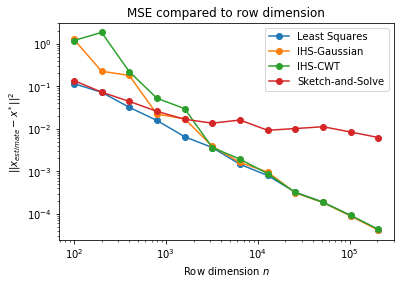

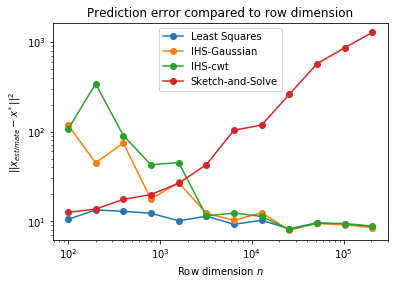

In [12]:
test_all_methods_samples(5) 

##### Experiment 2:  Comparing convergence with sketch size and number of iterations.

We now show that the CountSketch transform has comparable performance to the Gaussian sketch with respect to convergence rate and the required number of iterations.  Again, we take the experimental setup from the paper as follows:

Data dimensionality $(n,d) = (6000,200)$.
Sketch size $m = \gamma d $ for $ \gamma \in \{4,6,8,10\}$

The two experiments are (a) log error to least squares solution (b) log error to truth both versus number of iterations.

In [13]:
X, y, x_star = generate_data(nsamples=6000, nfeatures=200)
n,d = X.shape
gamma_vals = [4,6,8,10]
number_iterations = range(0,40, 5)

In [19]:
# setup independent variables
cwt_vs_lsq_errors = {gamma_vals[i]: np.zeros((len(number_iterations),1))\
                      for i in range(len(gamma_vals))}

cwt_vs_truth_errors = {gamma_vals[i]: np.zeros((len(number_iterations),1))\
                      for i in range(len(gamma_vals))}

gauss_vs_lsq_errors = {gamma_vals[i]: np.zeros((len(number_iterations),1))\
                      for i in range(len(gamma_vals))}

gauss_vs_truth_errors = {gamma_vals[i]: np.zeros((len(number_iterations),1))\
                      for i in range(len(gamma_vals))}

# Least squares estimator
optimal = sp.linalg.lstsq(X,y)
x_ls = optimal[0]
lsq_vs_truth_errors = np.log(1/np.sqrt(n)*norm(X@(x_ls-x_star))*lsq_vs_truth_errors)

/Users/cdickens/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


In [26]:
# This is the experiment for cwt aka counsketch transform
for gamma in gamma_vals:
    sketch_size = int(gamma*d)
    
    for ii in range(len(number_iterations)):
        print("Testing gamma: {}, num_iterations: {}".format(gamma,ii))
        iter_num = number_iterations[ii]
    
    
        # x_t is IHS output after iter_num iterations
        x_t = iterative_hessian_cwt(data=X,targets=y,
                            sketch_size=sketch_size,num_iters=iter_num)
    
        cwt_vs_lsq_errors[gamma][ii] = 1/np.sqrt(n)*norm(X@(x_t-x_ls))
        cwt_vs_truth_errors[gamma][ii] = 1/np.sqrt(n)*norm(X@(x_t-x_star))
        

Testing gamma: 4, num_iterations: 0
Testing gamma: 4, num_iterations: 1
Testing gamma: 4, num_iterations: 2
Testing gamma: 4, num_iterations: 3
Testing gamma: 4, num_iterations: 4
Testing gamma: 4, num_iterations: 5
Testing gamma: 4, num_iterations: 6
Testing gamma: 4, num_iterations: 7
Testing gamma: 6, num_iterations: 0
Testing gamma: 6, num_iterations: 1
Testing gamma: 6, num_iterations: 2
Testing gamma: 6, num_iterations: 3
Testing gamma: 6, num_iterations: 4
Testing gamma: 6, num_iterations: 5
Testing gamma: 6, num_iterations: 6
Testing gamma: 6, num_iterations: 7
Testing gamma: 8, num_iterations: 0
Testing gamma: 8, num_iterations: 1
Testing gamma: 8, num_iterations: 2
Testing gamma: 8, num_iterations: 3
Testing gamma: 8, num_iterations: 4
Testing gamma: 8, num_iterations: 5
Testing gamma: 8, num_iterations: 6
Testing gamma: 8, num_iterations: 7
Testing gamma: 10, num_iterations: 0
Testing gamma: 10, num_iterations: 1
Testing gamma: 10, num_iterations: 2
Testing gamma: 10, num_it

In [21]:
# This is the experiment for gaussian transform
for gamma in gamma_vals:
    sketch_size = int(gamma*d)
    
    for ii in range(len(number_iterations)):
        print("Testing gamma: {}, num_iterations: {}".format(gamma,ii))
        iter_num = number_iterations[ii]
    
    
        # x_t is IHS output after iter_num iterations
        x_t = iterative_hessian(data=X,targets=y,
                            sketch_size=sketch_size,num_iters=iter_num)
    
        gauss_vs_lsq_errors[gamma][ii] = 1/np.sqrt(n)*norm(X@(x_t-x_ls))
        gauss_vs_truth_errors[gamma][ii] = 1/np.sqrt(n)*norm(X@(x_t-x_star))
        

Testing gamma: 4, num_iterations: 0
Testing gamma: 4, num_iterations: 1
Testing gamma: 4, num_iterations: 2
Testing gamma: 4, num_iterations: 3
Testing gamma: 4, num_iterations: 4
Testing gamma: 4, num_iterations: 5
Testing gamma: 4, num_iterations: 6
Testing gamma: 4, num_iterations: 7
Testing gamma: 6, num_iterations: 0
Testing gamma: 6, num_iterations: 1
Testing gamma: 6, num_iterations: 2
Testing gamma: 6, num_iterations: 3
Testing gamma: 6, num_iterations: 4
Testing gamma: 6, num_iterations: 5
Testing gamma: 6, num_iterations: 6
Testing gamma: 6, num_iterations: 7
Testing gamma: 8, num_iterations: 0
Testing gamma: 8, num_iterations: 1
Testing gamma: 8, num_iterations: 2
Testing gamma: 8, num_iterations: 3
Testing gamma: 8, num_iterations: 4
Testing gamma: 8, num_iterations: 5
Testing gamma: 8, num_iterations: 6
Testing gamma: 8, num_iterations: 7
Testing gamma: 10, num_iterations: 0
Testing gamma: 10, num_iterations: 1
Testing gamma: 10, num_iterations: 2
Testing gamma: 10, num_it

Text(0.5,1,'Error to least-squares solution vs iteration - CountSketch')

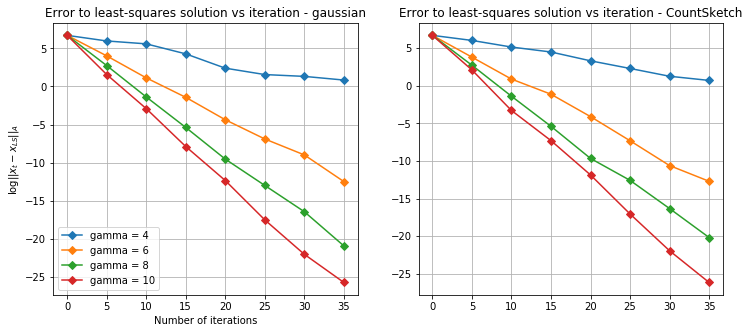

In [27]:
## MSE plots

fig, ax = plt.subplots(nrows=1, ncols=2,
                       figsize=(12,5),
                       sharey=False, sharex=True)

for gamma in gamma_vals:
    ax[0].plot(number_iterations, np.log(gauss_vs_lsq_errors[gamma]),
            '-D', label="gamma = {}".format(gamma))
    ax[0].grid(True)
    ax[1].plot(number_iterations, np.log(cwt_vs_lsq_errors[gamma]),
            '-D', label="gamma = {}".format(gamma))
    ax[1].grid(True)
ax[0].legend()
ax[0].set_xlabel("Number of iterations")
ax[0].set_ylabel("$\log ||x_t - x_{LS} ||_A$")
ax[0].set_title('Error to least-squares solution vs iteration - gaussian')
ax[1].set_title('Error to least-squares solution vs iteration - CountSketch')

Text(0.5,1,'Log error to truth vs iteration - CountSketch')

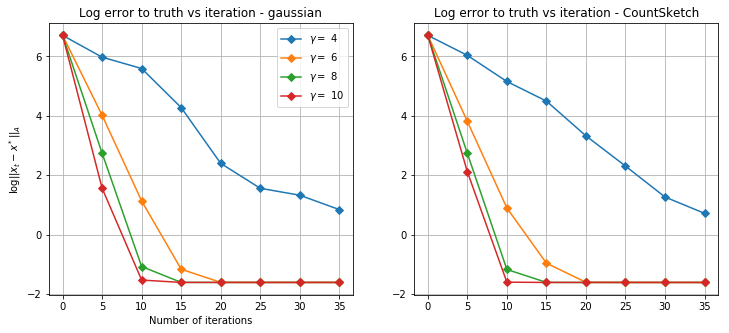

In [29]:
## Prediction MSE plots

fig, ax = plt.subplots(nrows=1, ncols=2,
                       figsize=(12,5),
                       sharey=False, sharex=True)

for gamma in gamma_vals:
    ax[0].plot(number_iterations, np.log(gauss_vs_truth_errors[gamma]),
            '-D', label="$\gamma =$ {}".format(gamma))
    ax[0].grid(True)
    ax[1].plot(number_iterations, np.log(cwt_vs_truth_errors[gamma]),
            '-D', label="$\gamma =$ {}".format(gamma))
    ax[1].grid(True)
ax[0].legend()
ax[0].set_xlabel("Number of iterations")
ax[0].set_ylabel("$\log ||x_t - x^* ||_A$")
ax[0].set_title('Log error to truth vs iteration - gaussian')
ax[1].set_title('Log error to truth vs iteration - CountSketch')

##### Experiment 3: Error compared to data dimensionality.

Generate a random least squares instance of dimensionality $d \in \{ 16, 32, 64, 128, 256 \}$ with sample size $n = 100d$.  Run IHS for $N = 4$ iterations and with a sketch size of $m = 6d$ for IHS (both gaussian and cwt) and $M = Nm = 24d$ for sketch and solve.